# 三角板关键点检测预测-Python API

同济子豪兄 2023-4-4

## 进入 mmpose 主目录

In [2]:
import os
os.chdir('mmpose')

## 导入工具包

In [2]:
import cv2
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import torch

import mmcv
from mmcv import imread
import mmengine
from mmengine.registry import init_default_scope

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.evaluation.functional import nms
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples

from mmdet.apis import inference_detector, init_detector

In [3]:
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 载入待测图像

In [4]:
img_path = 'data/test_ear/ear_pic.jpg'

In [5]:
# Image.open(img_path)

## 准备好的模型文件

In [6]:
## 目标检测模型

# Faster R CNN
# data/faster_r_cnn_triangle.py
# checkpoint/faster_r_cnn_triangle_epoch_50_202305120846-76d9dde3.pth

# RTMDet-Tiny
# data/rtmdet_tiny_triangle.py
# checkpoint/rtmdet_tiny_triangle_epoch_200_202305120847-3cd02a8f.pth

## 关键点检测模型

# data/rtmpose-s_triangle_8xb256-420e_coco-256x192.py
# checkpoint/rtmpose_s_triangle_300-34bfaeb2_20230512.pth

## 构建目标检测模型RTMDet


In [8]:
# RTMDet 三角板检测
detector = init_detector(
    'data/rtmdet_tiny_ear.py',
    'checkpoint/best_coco_bbox_mAP_epoch_175.pth',
    device=device
)

Loads checkpoint by local backend from path: checkpoint/best_coco_bbox_mAP_epoch_175.pth


## 构建关键点检测模型

In [9]:
pose_estimator = init_pose_estimator(
    'data/rtmpose-s-ear.py',
    'checkpoint/best_PCK_epoch_300.pth',
    device=device,
    cfg_options={'model': {'test_cfg': {'output_heatmaps': True}}}
)

Loads checkpoint by local backend from path: checkpoint/best_PCK_epoch_300.pth


## 预测-目标检测

In [10]:
init_default_scope(detector.cfg.get('default_scope', 'mmdet'))

06/05 07:24:00 - mmengine - WARNING - The current default scope "mmpose" is not "mmdet", `init_default_scope` will force set the currentdefault scope to "mmdet".


In [11]:
# 获取目标检测预测结果
detect_result = inference_detector(detector, img_path)

/root/miniconda3/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [13]:
detect_result.keys()

['ignored_instances', 'pred_instances', 'gt_instances']

In [14]:
# 预测类别
detect_result.pred_instances.labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [15]:
# 置信度
detect_result.pred_instances.scores

tensor([0.8837, 0.1992, 0.1335, 0.1104, 0.0842, 0.0750, 0.0730, 0.0606, 0.0553,
        0.0521, 0.0496, 0.0494, 0.0484, 0.0465, 0.0461, 0.0455, 0.0450, 0.0428,
        0.0414, 0.0409, 0.0402, 0.0399, 0.0397, 0.0395, 0.0392, 0.0389, 0.0386,
        0.0379, 0.0377, 0.0375, 0.0373, 0.0372, 0.0371, 0.0365, 0.0362, 0.0359,
        0.0355, 0.0339, 0.0338, 0.0331, 0.0329, 0.0315, 0.0311, 0.0309, 0.0305,
        0.0305, 0.0301, 0.0299, 0.0297, 0.0290, 0.0279, 0.0278, 0.0277, 0.0275,
        0.0273, 0.0260, 0.0249, 0.0248, 0.0248, 0.0247, 0.0243, 0.0236, 0.0233,
        0.0232, 0.0229, 0.0223, 0.0221, 0.0220, 0.0220, 0.0217, 0.0216, 0.0213,
        0.0212, 0.0208, 0.0208, 0.0207, 0.0206, 0.0206, 0.0206, 0.0203, 0.0201,
        0.0200, 0.0196, 0.0196, 0.0193, 0.0192, 0.0191, 0.0191, 0.0191, 0.0191,
        0.0190, 0.0190, 0.0190, 0.0188, 0.0186, 0.0186, 0.0186, 0.0186, 0.0185,
        0.0184, 0.0179, 0.0178, 0.0178, 0.0172, 0.0172, 0.0170, 0.0168, 0.0166,
        0.0165, 0.0164, 0.0164, 0.0162, 

In [14]:
# 框坐标：左上角X坐标、左上角Y坐标、右下角X坐标、右下角Y坐标
# detect_result.pred_instances.bboxes

## 置信度阈值过滤，获得最终目标检测预测结果

In [16]:
# 置信度阈值
CONF_THRES = 0.5

In [17]:
pred_instance = detect_result.pred_instances.cpu().numpy()
bboxes = np.concatenate((pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
bboxes = bboxes[np.logical_and(pred_instance.labels == 0, pred_instance.scores > CONF_THRES)]
bboxes = bboxes[nms(bboxes, 0.3)][:, :4].astype('int')

In [18]:
bboxes

array([[ 853, 1205, 2128, 3442]])

## 预测-关键点

In [19]:
# 获取每个 bbox 的关键点预测结果
pose_results = inference_topdown(pose_estimator, img_path, bboxes)

06/05 07:26:33 - mmengine - WARNING - The current default scope "mmdet" is not "mmpose", `init_default_scope` will force set the currentdefault scope to "mmpose".


/root/autodl-tmp/pythonProject/openmmlab_ai/ear_pred_kakasi1985/mmpose/mmpose/models/heads/coord_cls_heads/rtmcc_head.py:217: UserWarning: The predicted simcc values are normalized for visualization. This may cause discrepancy between the keypoint scores and the 1D heatmaps.
  warnings.warn('The predicted simcc values are normalized for '


In [20]:
len(pose_results)

1

In [21]:
# 把多个bbox的pose结果打包到一起
data_samples = merge_data_samples(pose_results)

In [22]:
data_samples.keys()

['gt_instances', 'pred_instances', '_pred_heatmaps', 'pred_fields']

## 预测结果-关键点坐标

In [23]:
keypoints = data_samples.pred_instances.keypoints.astype('int')

In [24]:
keypoints

array([[[1741, 2509],
        [1566, 1280],
        [1370, 2268],
        [1479, 2896],
        [1670, 2290],
        [1332, 2148],
        [1479, 2552],
        [1556, 2481],
        [1457, 2460],
        [1545, 2574],
        [1747, 1952],
        [1304, 2356],
        [1741, 1744],
        [1627, 1706],
        [1648, 2006],
        [2036, 2077],
        [1971, 2569],
        [1878, 3011],
        [1097, 2356],
        [1441, 3060],
        [1403, 1864]]])

In [25]:
keypoints.shape

(1, 21, 2)

In [26]:
# 索引为 0 的框，每个关键点的坐标
keypoints[0,:,:]

array([[1741, 2509],
       [1566, 1280],
       [1370, 2268],
       [1479, 2896],
       [1670, 2290],
       [1332, 2148],
       [1479, 2552],
       [1556, 2481],
       [1457, 2460],
       [1545, 2574],
       [1747, 1952],
       [1304, 2356],
       [1741, 1744],
       [1627, 1706],
       [1648, 2006],
       [2036, 2077],
       [1971, 2569],
       [1878, 3011],
       [1097, 2356],
       [1441, 3060],
       [1403, 1864]])

## 预测结果-关键点热力图

In [27]:
# 每一类关键点的预测热力图
data_samples.pred_fields.heatmaps.shape

(21, 4000, 3008)

In [28]:
kpt_idx = 1
heatmap = data_samples.pred_fields.heatmaps[kpt_idx,:,:]

In [29]:
heatmap.shape

(4000, 3008)

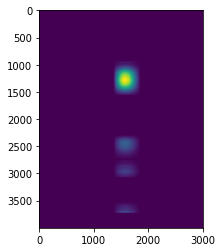

In [30]:
# 索引为 idx 的关键点，在全图上的预测热力图
plt.imshow(heatmap)
plt.show()

## OpenCV可视化

In [31]:
img_bgr = cv2.imread(img_path)

In [35]:
# 检测框的颜色
bbox_color = (150,0,0)
# 检测框的线宽
bbox_thickness = 20
# 关键点半径
kpt_radius = 70
# 连接线宽
skeleton_thickness = 30

In [36]:
# 耳朵关键点检测数据集-元数据（直接从config配置文件中粘贴）
dataset_info = {
    'keypoint_info':{
        0: {'name': '肾上腺', 'id': 0, 'color': [101, 205, 228], 'type': '', 'swap': ''},
        1: {'name': '耳尖', 'id': 1, 'color': [240, 128, 128], 'type': '', 'swap': ''},
        2: {'name': '胃', 'id': 2, 'color': [154, 205, 50], 'type': '', 'swap': ''},
        3: {'name': '眼', 'id': 3, 'color': [34, 139, 34], 'type': '', 'swap': ''},
        4: {'name': '口', 'id': 4, 'color': [139, 0, 0], 'type': '', 'swap': ''},
        5: {'name': '肝', 'id': 5, 'color': [255, 165, 0], 'type': '', 'swap': ''},
        6: {'name': '对屏尖', 'id': 6, 'color': [255, 0, 255], 'type': '', 'swap': ''},
        7: {'name': '心', 'id': 7, 'color': [255, 255, 0], 'type': '', 'swap': ''},
        8: {'name': '肺', 'id': 8, 'color': [29, 123,243], 'type': '', 'swap': ''},
        9: {'name': '肺2', 'id': 9, 'color': [0, 255, 255], 'type': '', 'swap': ''},
        10: {'name': '膀胱', 'id': 10, 'color': [128, 0, 128], 'type': '', 'swap': ''},
        11: {'name': '脾', 'id': 11, 'color': [74, 181, 57], 'type': '', 'swap': ''},
        12: {'name': '角窝中', 'id': 12, 'color': [165, 42, 42], 'type': '', 'swap': ''},
        13: {'name': '神门', 'id': 13, 'color': [128, 128, 0], 'type': '', 'swap': ''},
        14: {'name': '肾', 'id': 14, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        15: {'name': '耳门', 'id': 15, 'color': [34, 139, 34], 'type': '', 'swap': ''},
        16: {'name': '听宫', 'id': 16, 'color': [255, 129, 0], 'type': '', 'swap': ''},
        17: {'name': '听会', 'id': 17, 'color': [70, 130, 180], 'type': '', 'swap': ''},
        18: {'name': '肩', 'id': 18, 'color': [63, 103,165], 'type': '', 'swap': ''},
        19: {'name': '扁桃体', 'id': 19, 'color': [66, 77, 229], 'type': '', 'swap': ''},
        20: {'name': '腰骶椎', 'id': 20, 'color': [255, 105, 180], 'type': '', 'swap': ''}
    },
    'skeleton_info': {
        0: {'link':('眼','扁桃体'),'id': 0,'color': [100,150,200]},
        1: {'link':('耳门','听宫'),'id': 1,'color': [200,100,150]},
        2: {'link':('听宫','听会'),'id': 2,'color': [150,120,100]},
        3: {'link':('耳门','听会'),'id': 3,'color': [66,77,229]}
    }
}

In [37]:
# 关键点类别和关键点ID的映射字典
label2id = {}
for each in dataset_info['keypoint_info'].items():
    label2id[each[1]['name']] = each[0]

In [38]:
for bbox_idx, bbox in enumerate(bboxes): # 遍历每个检测框

    # 画框
    img_bgr = cv2.rectangle(img_bgr, (bbox[0], bbox[1]), (bbox[2], bbox[3]), bbox_color, bbox_thickness)
    
    # 索引为 0 的框，每个关键点的坐标
    keypoints = data_samples.pred_instances.keypoints[bbox_idx,:,:].astype('int')

    # 画连线
    for skeleton_id, skeleton in dataset_info['skeleton_info'].items(): # 遍历每一种连接
        skeleton_color = skeleton['color']
        srt_kpt_id = label2id[skeleton['link'][0]] # 起始点的类别 ID
        srt_kpt_xy = keypoints[srt_kpt_id]         # 起始点的 XY 坐标
        dst_kpt_id = label2id[skeleton['link'][1]] # 终止点的类别 ID
        dst_kpt_xy = keypoints[dst_kpt_id]         # 终止点的 XY 坐标
        img_bgr = cv2.line(img_bgr, (srt_kpt_xy[0],srt_kpt_xy[1]),(dst_kpt_xy[0],dst_kpt_xy[1]),color=skeleton_color,thickness=skeleton_thickness)
    
    # 画关键点
    for kpt_idx, kpt_xy in enumerate(keypoints): # 遍历该检测框中的每一个关键点
        kpt_color = dataset_info['keypoint_info'][kpt_idx]['color']
        img_bgr = cv2.circle(img_bgr, (kpt_xy[0], kpt_xy[1]), kpt_radius, kpt_color, -1)

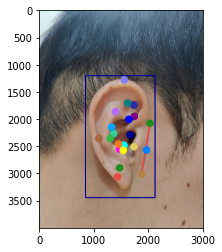

In [46]:
plt.imshow(img_bgr[:,:,::-1])
plt.show()

In [47]:
cv2.imwrite('outputs/ear_points.jpg', img_bgr)

True

## MMPose官方可视化工具`visualizer`

In [41]:
# 半径
pose_estimator.cfg.visualizer.radius = 30
# 线宽
pose_estimator.cfg.visualizer.line_width = 20
visualizer = VISUALIZERS.build(pose_estimator.cfg.visualizer)
# 元数据
visualizer.set_dataset_meta(pose_estimator.dataset_meta)

06/05 07:36:32 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


In [38]:
# 元数据
# pose_estimator.dataset_meta

In [42]:
img = mmcv.imread(img_path)
img = mmcv.imconvert(img, 'bgr', 'rgb')

img_output = visualizer.add_datasample(
            'result',
            img,
            data_sample=data_samples,
            draw_gt=False,
            draw_heatmap=True,
            draw_bbox=True,
            show=False,
            show_kpt_idx=True,
            wait_time=0,
            out_file='outputs/ear_points_heap.jpg',
            kpt_thr=0.3
)

In [43]:
img_output.shape

(8000, 3008, 3)

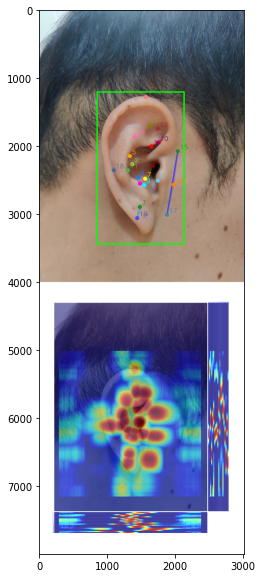

In [44]:
plt.figure(figsize=(10, 10))
plt.imshow(img_output)
plt.show()

## 目标检测预测-视频

In [7]:
# RTMPose
!python demo/inferencer_demo.py \
        data/test_ear/ear_video.mp4 \
        --pose2d data/rtmpose-s-ear.py \
        --pose2d-weights checkpoint/best_PCK_epoch_300.pth \
        --det-model data/rtmdet_tiny_ear.py \
        --det-weights checkpoint/best_coco_bbox_mAP_epoch_175.pth \
        --device cuda:0 \
        --draw-bbox \
        --kpt-thr 0.3 \
        --vis-out-dir outputs/rtmpose-s-ear/vis \
        --pred-out-dir outputs/rtmpose-s-ear/preds

Loads checkpoint by local backend from path: checkpoint/best_PCK_epoch_300.pth
06/05 10:46:43 - mmengine - WARNING - Failed to search registry with scope "mmpose" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmpose" is a correct scope, or whether the registry is initialized.
06/05 10:46:43 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.
Loads checkpoint by local backend from path: checkpoint/best_coco_bbox_mAP_epoch_175.pth
06/05 10:46:43 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a correct scope, or whether the registry is initialized.
/roo